In [1]:
import logging
import os
import pandas as pd
import json

from pathlib import Path
from copy import deepcopy

%load_ext autoreload
%autoreload 2

# Disable logging of the program in the notebook
os.environ["LOGLEVEL"] = "CRITICAL"

logging.basicConfig()
logging.root.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('__main__')
logger.setLevel(os.environ.get("LOGLEVEL", logging.FATAL))

pybooklogger = logging.getLogger('pybook')
pybooklogger.setLevel(logging.DEBUG)

%aimport setup

from setup import *

# Track Layout
Calculate the layout of the dutch railway system


In [2]:
layout_file =   "../data/prorail/parsed/netherlands-schiphol.json"
layout = Layout(layout_file)

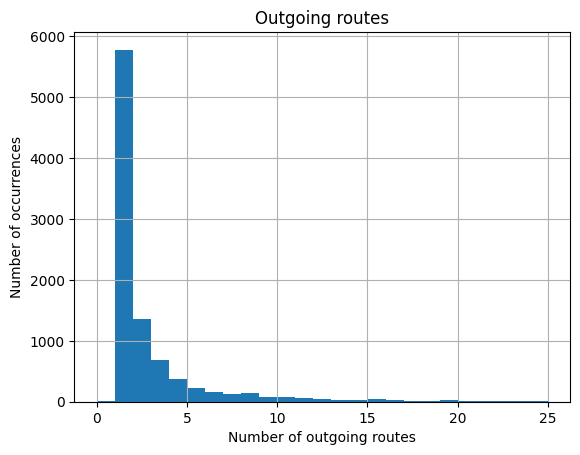

In [3]:
edges_df = pd.DataFrame({"Outgoing routes": [len(n.outgoing) for n in layout.g_block.nodes.values() if len(n.outgoing) <= 25]})
hist = edges_df.hist(bins=25, )
plt.xlabel("Number of outgoing routes")
plt.ylabel("Number of occurrences")
plt.show()

# Experiment Runtime Agents


In [4]:
scenario_file = "../data/prorail/scenarios/RT/2025-07-04_1.json"
agents = []
try:
    base_path = Path(__file__).parent
    file_path = (base_path / scenario_file).resolve()
    data = json.load(open(file_path))
except:
    data = json.load(open(scenario_file))

types = {x["name"]: x for x in data["types"]}
for trainNumber, entry in enumerate(data["trains"]):
    trainNumber += 1
    move = entry["movements"][0]
    velocity = types[entry["trainUnitTypes"][0]]["speed"] / 3.6

    agent = Agent(trainNumber, move["startLocation"], move["endLocation"], velocity, move["startTime"],
                  endTime=move["endTime"],
                  startTimeHuman=str(timedelta(seconds=move["startTime"])),
                  endTimeHuman=str(timedelta(seconds=move["endTime"])),
                  trainNumber=entry["trainNumber"],
                  trainUnitTypes=entry["trainUnitTypes"],
                  stops=move["stops"],
    )
    agents.append(agent)
agent_df = pd.DataFrame([agent.__dict__ for agent in agents])
series_3500o = agent_df.loc[(agent_df['trainNumber'].str.startswith("35", na=False)) & (agent_df['trainNumber'].astype(int) % 2 == 1)].sort_values("start_time")
agent_df

id  origin destination   velocity  start_time  endTime startTimeHuman  \
0      1  RSD|4a        VS|3  38.888889      1320.0   5160.0        0:22:00   
1      2  RTD|14       UT|12  38.888889      1260.0   3480.0        0:21:00   
2      3   HAD|1      ASD|2a  38.888889       240.0   1560.0        0:04:00   
3      4  GVC|10      ASD|2a  38.888889      3720.0   6960.0        1:02:00   
4      5    UT|7       DDR|2  38.888889      1680.0   7680.0        0:28:00   
..   ...     ...         ...        ...         ...      ...            ...   
107  108   GVC|3      DDR|3a  38.888889      4320.0   7500.0        1:12:00   
108  109  RSD|4a        VS|2  38.888889      3240.0   6720.0        0:54:00   
109  110  ASD|2a      GVC|10  38.888889       360.0   3540.0        0:06:00   
110  111  GVC|11       LLS|3  38.888889      4920.0  11940.0        1:22:00   
111  112    UT|5      GVC|10  38.888889       660.0   4500.0        0:11:00   

    endTimeHuman trainNumber trainUnitTypes  \
0        1:26:00        2222         [VIRM]   
1        0:58:00        2037          [SLT]   
2        0:26:00        2124         [VIRM]   
3        1:56:00        2130         [VIRM]   
4        2:08:00        3532         [VIRM]   
..           ...         ...            ...   
107      2:05:00        5143          [SNG]   
108      1:52:00        6524          [SNG]   
109      0:59:00        2141         [VIRM]   
110      3:19:00        4343          [SLT]   
111      1:15:00        3130         [VIRM]   

                                                 stops  
0    [{'expected_arrival': 1860.0, 'location': 'BGN...  
1    [{'expected_arrival': 1740.0, 'location': 'RTA...  
2    [{'expected_arrival': 540.0, 'location': 'HLM|...  
3    [{'expected_arrival': 4380.0, 'location': 'LED...  
4    [{'expected_arrival': 2640.0, 'location': 'ASB...  
..                                                 ...  
107  [{'expected_arrival': 4500.0, 'location': 'GV|...  
108  [{'expected_arrival': 3780.0, 'location': 'BGN...  
109  [{'expected_arrival': 660.0, 'location': 'ASS|...  
110  [{'expected_arrival': 5100.0, 'location': 'LAA...  
111  [{'expected_arrival': 1620.0, 'location': 'ASB...  

[112 rows x 11 columns]

In [5]:
longest = series_3500o.loc[series_3500o['stops'].map(len).idxmax()]

# This train would be at 2700 at GV|6, we will be replanning its path till ASDZ|2
longest

id                                                               61
origin                                                        DDR|2
destination                                                    VL|3
velocity                                                  38.888889
start_time                                                   1500.0
endTime                                                     13440.0
startTimeHuman                                              0:25:00
endTimeHuman                                                3:44:00
trainNumber                                                    3541
trainUnitTypes                                               [VIRM]
stops             [{'expected_arrival': 2160.0, 'location': 'RTB...
Name: 60, dtype: object

In [6]:
stops_df = pd.DataFrame(longest["stops"])
r_rtd = stops_df.loc[stops_df["location"].str.contains("RTD", na=False)]
r_asdz = stops_df.loc[stops_df["location"].str.contains("ASDZ", na=False)]

i_rtd = r_rtd.index[0] + 1
i_asdz = r_asdz.index[0]
stops = longest["stops"][i_rtd:i_asdz]

print(f"i_rtd={i_rtd}, i_asdz={i_asdz}")
print(f"stops={stops}")

move = {
    "endLocation": r_asdz["location"].iloc[0],
    "endTime": r_asdz["expected_arrival"].iloc[0],
    "startLocation": r_rtd["location"].iloc[0],
    "startTime": r_rtd["time"].iloc[0],
    "stops": stops,
}

block_path = layout.get_path_for_agent(move, longest["trainNumber"], longest["velocity"])

def filter_origin(n):
    return n.split("-")[1].split("|")[0]

allowed_nodes = {filter_origin(block_path[0].from_node.name)}
for e in block_path:
    allowed_nodes.add(filter_origin(e.to_node.name))
allowed_nodes

i_rtd=2, i_asdz=8
stops=[{'expected_arrival': 2760.0, 'location': 'SDM|5', 'time': 2760.0}, {'expected_arrival': 3180.0, 'location': 'DT|1', 'time': 3180.0}, {'expected_arrival': 3600.0, 'location': 'GV|6', 'time': 3720.0}, {'expected_arrival': 3900.0, 'location': 'LAA|6', 'time': 3900.0}, {'expected_arrival': 4440.0, 'location': 'LEDN|5b', 'time': 4500.0}, {'expected_arrival': 5400.0, 'location': 'SHL|1', 'time': 5460.0}]


{'Asdzo',
 'Asra',
 'Asra_Shl',
 'Dt',
 'Dt_Gv',
 'Dt_Sdm',
 'Dtcp',
 'Gv',
 'Gvm',
 'Gvm_Ledn',
 'Hfd',
 'Hfd_Ledn',
 'Hfd_Shl',
 'Laa',
 'Ledn',
 'Rmoa_Rtd',
 'Rtd',
 'Sdm',
 'Shl'}

In [10]:

exp_settings = {
    "origin": r_rtd["location"].iloc[0],
    "destination": r_asdz["location"].iloc[0],
    "start_time": r_rtd["time"].iloc[0],
    "max_buffer_time": 900,
    "use_recovery_time": True,
    "filter_agents": longest["id"],
    "metadata": {
        "expected_arrival": r_asdz["expected_arrival"].iloc[0],
    }
}
set_default(exp_settings)
exp_settings

{'origin': 'RTD|9',
 'destination': 'ASDZ|2',
 'start_time': 2460.0,
 'max_buffer_time': 900,
 'use_recovery_time': True,
 'filter_agents': 61,
 'metadata': {'expected_arrival': 5820.0,
  'color': 'Red',
  'label': 'No flexibility',
  'offset': 0},
 'velocity': 38.888888888888886}

In [8]:
scenario = Scenario(layout, scenario_file)

In [11]:
experiments = []
interval = 10
n_trains = len(data["trains"]) + 1
for idx in range(interval, n_trains, interval):
    origin = exp_settings["origin"]
    destination = exp_settings["destination"]
    velocity = exp_settings["velocity"]
    start_time = exp_settings["start_time"]
    max_buffer_time = exp_settings["max_buffer_time"]
    use_recovery_time = exp_settings["use_recovery_time"]
    metadata = deepcopy(exp_settings["metadata"])
    metadata["label"] = f"{idx}"
    exp_settings["metadata"] = metadata

    filter_agents = set(range(idx + 1, n_trains))
    filter_agents.add(longest["id"])
    pybooklogger.info(f"Setting up experiment {exp_settings}")

    origin_signal = scenario.l.station_to_block(origin, direction=1)
    destination_signal = scenario.l.station_to_block(destination, direction=1)
    agent = Agent(longest["id"], origin_signal, destination_signal, velocity, start_time)

    experiments.append(Experiment(scenario, agent, filter_agents, max_buffer_time, use_recovery_time, metadata))


INFO:pybook:Setting up experiment {'origin': 'RTD|9', 'destination': 'ASDZ|2', 'start_time': 2460.0, 'max_buffer_time': 900, 'use_recovery_time': True, 'filter_agents': 61, 'metadata': {'expected_arrival': 5820.0, 'color': 'Red', 'label': '10', 'offset': 0}, 'velocity': 38.888888888888886}
INFO:pybook:Setting up experiment {'origin': 'RTD|9', 'destination': 'ASDZ|2', 'start_time': 2460.0, 'max_buffer_time': 900, 'use_recovery_time': True, 'filter_agents': 61, 'metadata': {'expected_arrival': 5820.0, 'color': 'Red', 'label': '20', 'offset': 0}, 'velocity': 38.888888888888886}
INFO:pybook:Setting up experiment {'origin': 'RTD|9', 'destination': 'ASDZ|2', 'start_time': 2460.0, 'max_buffer_time': 900, 'use_recovery_time': True, 'filter_agents': 61, 'metadata': {'expected_arrival': 5820.0, 'color': 'Red', 'label': '30', 'offset': 0}, 'velocity': 38.888888888888886}
INFO:pybook:Setting up experiment {'origin': 'RTD|9', 'destination': 'ASDZ|2', 'start_time': 2460.0, 'max_buffer_time': 900, 'u

### Blocking staircase diagram
Showing the route of the agent with the most stops, its quite long.


In [24]:
exp = experiments[-1]
exp.s.plot(longest["id"], exp.block_intervals, exp.buffer_times, exp.recovery_times, False)

In [12]:
timeout = 600
# experiments = experiments[:-10]
run_experiments(experiments, timeout, filter_tracks=allowed_nodes)

DEBUG:pybook.setup:Running: ../search/buildDir/atsipp.exe --start r-Rtd|278 --goal r-Asdzo|764 --edgegraph output --search repeat --startTime 2460.0
DEBUG:pybook.setup:repeat output: ['<0,inf,inf,inf> <-inf,2460,4373.84,4373.84>', '<2460,inf,inf,inf> <2460,3072.07,4373.84,4985.91>', '<3072.07,inf,inf,inf> <-inf,3072.08,4985.91,4985.91>', '<2460,3072.07,4373.84,4985.91> <-inf,3072.08,4985.91,4985.91>', '<3072.08,inf,inf,inf> <3072.08,3972.07,4985.91,5885.91>', '<3072.07,3072.08,4985.91,4985.91> <3072.08,3972.07,4985.91,5885.91>', '<2460,3072.07,4373.84,4985.91> <3072.07,3072.08,4985.91,4985.91>', 'Nodes generated: 250 Nodes decreased: 195 Nodes expanded: 144', '<-inf,2460,4373.84,4373.84>, <2460,3072.07,4373.84,4985.91>, <3072.07,3072.08,4985.91,4985.91>, <3072.08,3972.07,4985.91,5885.91>, <3972.07,inf,inf,inf>, ', 'r-Rtd|278 <0,3075.42> ns:15 []', 'r-Rtd|178 <0,3086.91> ns:1 []', 'r-Rmoa_Rtd|168 <0,3407.73> ns:2 []', 'r-Rmoa_Rtd|146 <0,3430.32> ns:6 []', 'r-Rmoa_Rtd|122 <0,3451.82> ns:

## Results


### Time statistics

In [27]:
def sum_cols(df1, cols, name):
    df2 = df1.drop(columns=cols)
    df2[name] = df1[cols].sum(axis=1)
    return df2

time_df = pd.DataFrame([exp.get_running_time() for exp in experiments], index=[exp.metadata['label'] for exp in experiments])

setup_cols = ["track graph creation", "routing graph creation"]
recompute_cols = ["unsafe interval generation", "safe interval generation", "bt and crt generation", "converting routes to blocks"]
search_cols = ["FlexSIPP search time"]

time_df = sum_cols(time_df, setup_cols, "Setup Time")
time_df = sum_cols(time_df, recompute_cols, "Recompute Time")
time_df = sum_cols(time_df, search_cols, "Search Time")
time_df.loc[time_df["Search Time"] > -1]["Search Time"].plot()
plt.xlabel("Number of agents")
plt.ylabel("Search Time")
plt.title("Run time of FlexSIPP")
time_df.loc[time_df["Search Time"] > -1]["Search Time"]

10       0.512
20       0.977
30       1.390
40       4.230
50       6.633
60      11.674
70      12.664
80      14.242
90     142.305
100    136.972
110    279.780
Name: Search Time, dtype: float64

### Search Node Statistics


<AxesSubplot:>

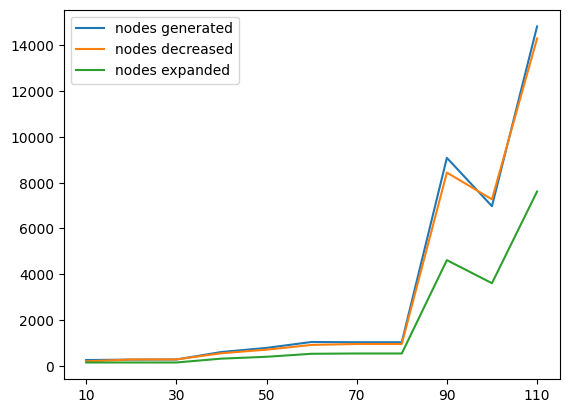

In [15]:
nodes_df = pd.DataFrame([exp.get_complexity() for exp in experiments], index=[exp.metadata['label'] for exp in experiments])

nodes_df.plot()

### Output paths found


In [33]:
for key, value in experiments[-1].results[3].items():
    delayed_trains = {i: v for i,v in enumerate(value[0][4]) if float(v[0]) > 0}
    print(f"{key.replace('r-', '')}\nearliest departure: {int(min(float(value[0][1]), float(value[0][2])) / 60)}\ndepart before: {int(float(value[0][2]) / 60)}\narrive at: {int((float(value[0][1]) + float(value[0][3])) / 60)}\ndelays trains: {delayed_trains}")

Rtd|278;Rtd|178;Rmoa_Rtd|168;Rmoa_Rtd|146;Rmoa_Rtd|122;Sdm|102;Sdm|78;Sdm|52;Dt_Sdm|838;Dt_Sdm|828;Dt_Sdm|822;Dt_Sdm|812;Dt_Sdm|806;Dtcp|6276;Dtcp|6256;Dtcp|6238;Dtcp|6218;Dt|6198;Dt|6178;Dt|6148;Dt_Gv|638;Dt_Gv|H624;Dt_Gv|624;Dt_Gv|616;Dt_Gv|608;Gv|360;Gv|320;Gv|244;Laa|216;Laa|1816;Gvm|188;Gvm|168;Gvm|866;Gvm_Ledn|856;Gvm_Ledn|846;Gvm_Ledn|836;Gvm_Ledn|826;Gvm_Ledn|816;Gvm_Ledn|806;Ledn|1114;Ledn|1066;Ledn|1030;Ledn|1992;Hfd_Ledn|1990;Hfd_Ledn|1986;Hfd_Ledn|1984;Hfd_Ledn|1982;Hfd_Ledn|1980;Hfd_Ledn|1978;Hfd_Ledn|1976;Hfd_Ledn|1974;Hfd_Ledn|1972;Hfd_Ledn|1970;Hfd|1232;Hfd|1212;Hfd|1152;Hfd|1138;Hfd|1118;Hfd_Shl|1776;Hfd_Shl|1762;Shl|1086;Shl|1068;Shl|1062;Shl|1032;Asra_Shl|1740;Asra_Shl|1726;Asra|1308;Asra|1024;Asdzo|704;Asdzo|1404;Asdzo|744;Asdzo|764
earliest departure: 41
depart before: 41
arrive at: 72
delays trains: {54: ['44.1098', '44.3617', '1673.91'], 57: ['256.562', '256.814', '546.673'], 107: ['52.6919', '52.9438', '426.887']}
Rtd|278;Rtd|178;Rmoa_Rtd|168;Rmoa_Rtd|146;Rmoa_R

### Path statistics


In [17]:
for exp in experiments:
    print(f"Differend paths found for {exp.metadata['label']}: {sum(exp.results[2].values())}")

Differend paths found for 10: 4
Differend paths found for 20: 4
Differend paths found for 30: 4
Differend paths found for 40: 7
Differend paths found for 50: 9
Differend paths found for 60: 11
Differend paths found for 70: 11
Differend paths found for 80: 11
Differend paths found for 90: 101
Differend paths found for 100: 75
Differend paths found for 110: 167
